**Importing necessary libraries**

In [110]:
#importing all libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import MinMaxScaler

from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [4]:
import warnings
warnings.filterwarnings('ignore')

**Importing dataset**

In [5]:
url = 'https://cdn.upgrad.com/UpGrad/temp/2f181ade-814a-430a-b721-769d6a9bf814/Country-data.csv'

country_data = pd.read_csv(url, index_col= None)
country_data.head() #checking 1st 5 rows of imported data

,country,child_mort,exports,health,imports,income,inflation,life_expec,total_fer,gdpp
0,Afghanistan,90.2,10.0,7.58,44.9,1610,9.44,56.2,5.82,553
1,Albania,16.6,28.0,6.55,48.6,9930,4.49,76.3,1.65,4090
2,Algeria,27.3,38.4,4.17,31.4,12900,16.10,76.5,2.89,4460
3,Angola,119.0,62.3,2.85,42.9,5900,22.40,60.1,6.16,3530
4,Antigua and Barbuda,10.3,45.5,6.03,58.9,19100,1.44,76.8,2.13,12200


**Converting columns 'export' , 'health', 'imports' into absolute values, versus % of GDP in there current form. This is a pre-requisite for appropriate determination of clusters and attributable data analysis**

In [6]:
country_data['exports_abs'] = 0
country_data['health_abs'] = 0
country_data['imports_abs'] = 0
country_data['exports_abs'] = country_data['exports'] * country_data['gdpp']
country_data['imports_abs'] = country_data['imports'] * country_data['gdpp']
country_data['health_abs'] = country_data['health'] * country_data['gdpp']

**Dropping variables which are converted to absolute value from '% of GDP'**

In [7]:
country_data = country_data.drop(['exports','imports','health'],axis=1)
country_data.head(10)

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs
0,Afghanistan,90.2,1610,9.440,56.2,5.82,553,5530.0,4191.74,24829.7
1,Albania,16.6,9930,4.490,76.3,1.65,4090,114520.0,26789.50,198774.0
2,Algeria,27.3,12900,16.100,76.5,2.89,4460,171264.0,18598.20,140044.0
3,Angola,119.0,5900,22.400,60.1,6.16,3530,219919.0,10060.50,151437.0
4,Antigua and Barbuda,10.3,19100,1.440,76.8,2.13,12200,555100.0,73566.00,718580.0
5,Argentina,14.5,18700,20.900,75.8,2.37,10300,194670.0,83430.00,164800.0
6,Armenia,18.1,6700,7.770,73.3,1.69,3220,66976.0,14168.00,145866.0
7,Australia,4.8,41400,1.160,82.0,1.93,51900,1027620.0,453087.00,1084710.0
8,Austria,4.3,43200,0.873,80.5,1.44,46900,2405970.0,515900.00,2241820.0
9,Azerbaijan,39.2,16000,13.800,69.1,1.92,5840,317112.0,34339.20,120888.0


**Quick stat on columns**

In [8]:
country_data.describe()

,child_mort,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,1.670000e+02,167.000000,1.670000e+02
mean,38.270060,17144.688623,7.781832,70.555689,2.947964,12964.155689,7.420619e+05,105673.320419,6.588352e+05
std,40.328931,19278.067698,10.570704,8.893172,1.513848,18328.704809,1.797389e+06,180140.890556,1.471081e+06
min,2.600000,609.000000,-4.210000,32.100000,1.150000,231.000000,1.076920e+02,1282.120000,6.510920e+01
25%,8.250000,3355.000000,1.810000,65.300000,1.795000,1330.000000,4.471400e+04,7853.550000,6.402150e+04
50%,19.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000,1.777440e+05,32188.600000,2.045580e+05
75%,62.100000,22800.000000,10.750000,76.800000,3.880000,14050.000000,7.278000e+05,97694.000000,7.719600e+05
max,208.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000,1.837500e+07,866360.000000,1.491000e+07


**Data types of different columns**

In [10]:
country_data.dtypes

country         object
child_mort     float64
income           int64
inflation      float64
life_expec     float64
total_fer      float64
gdpp             int64
exports_abs    float64
health_abs     float64
imports_abs    float64
dtype: object

**Shape of dataframe**

In [11]:
country_data.shape

(167, 10)

**# of nulls across columns**

In [12]:
country_data.isnull().sum()

country        0
child_mort     0
income         0
inflation      0
life_expec     0
total_fer      0
gdpp           0
exports_abs    0
health_abs     0
imports_abs    0
dtype: int64

**Given we do not have any null values, we do not need to do any null value treatments**

**Dataframe info**

In [13]:
country_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 167 entries, 0 to 166
Data columns (total 10 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   country      167 non-null    object 
 1   child_mort   167 non-null    float64
 2   income       167 non-null    int64  
 3   inflation    167 non-null    float64
 4   life_expec   167 non-null    float64
 5   total_fer    167 non-null    float64
 6   gdpp         167 non-null    int64  
 7   exports_abs  167 non-null    float64
 8   health_abs   167 non-null    float64
 9   imports_abs  167 non-null    float64
dtypes: float64(7), int64(2), object(1)
memory usage: 13.2+ KB


# **Box plots for all columns for outlier detection **

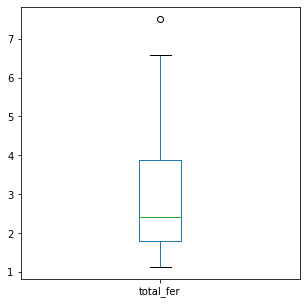

In [14]:
country_data_box_plot = country_data[["total_fer"]].copy()
country_data_box_plot.plot(kind='box', figsize=(5,5))
plt.show()

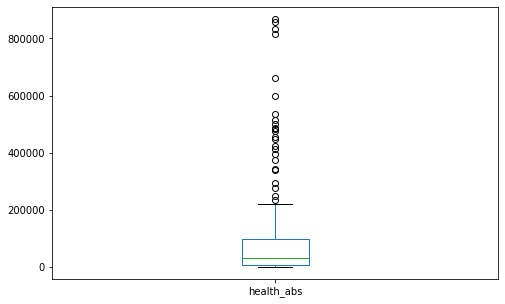

In [15]:
country_data_box_plot = country_data[["health_abs"]].copy()
country_data_box_plot.plot(kind='box', figsize=(8,5))
plt.show()

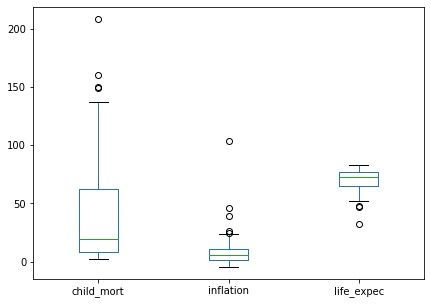

In [16]:
country_data_box_plot = country_data[["child_mort","inflation","life_expec"]].copy()
country_data_box_plot.plot(kind='box', figsize=(7,5))
plt.show()

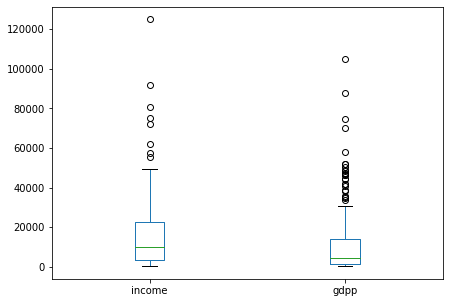

In [17]:
country_data_box_plot = country_data[["income","gdpp"]].copy()
country_data_box_plot.plot(kind='box', figsize=(7,5))
plt.show()

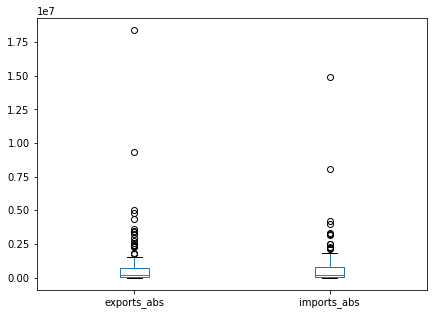

In [18]:
country_data_box_plot = country_data[["exports_abs","imports_abs"]].copy()
country_data_box_plot.plot(kind='box', figsize=(7,5))
plt.show()

**Insights:**


*   There are significant number of outliers across all columns, and outliers can significantly impact the result of clustering. 
*   Thus we would be imputing outliers through normal curve, i.e. impute any value which is greater than +/- 3 standard deviation from mean to the 3 standard deviation boundary.
*   We are not dropping outliers because this may result in dropping of countries with highest "child mortality" or "lowest life expectancy". These are the countries which actually are in dire need of aid, and thus dropping outliers would adversely impact business objective.

**Statistical outlier treatment:** Imputing any outlier which is beyond interquartile range, to interquartile range boundaries: median +/- (2.698 * Standard Deviation).
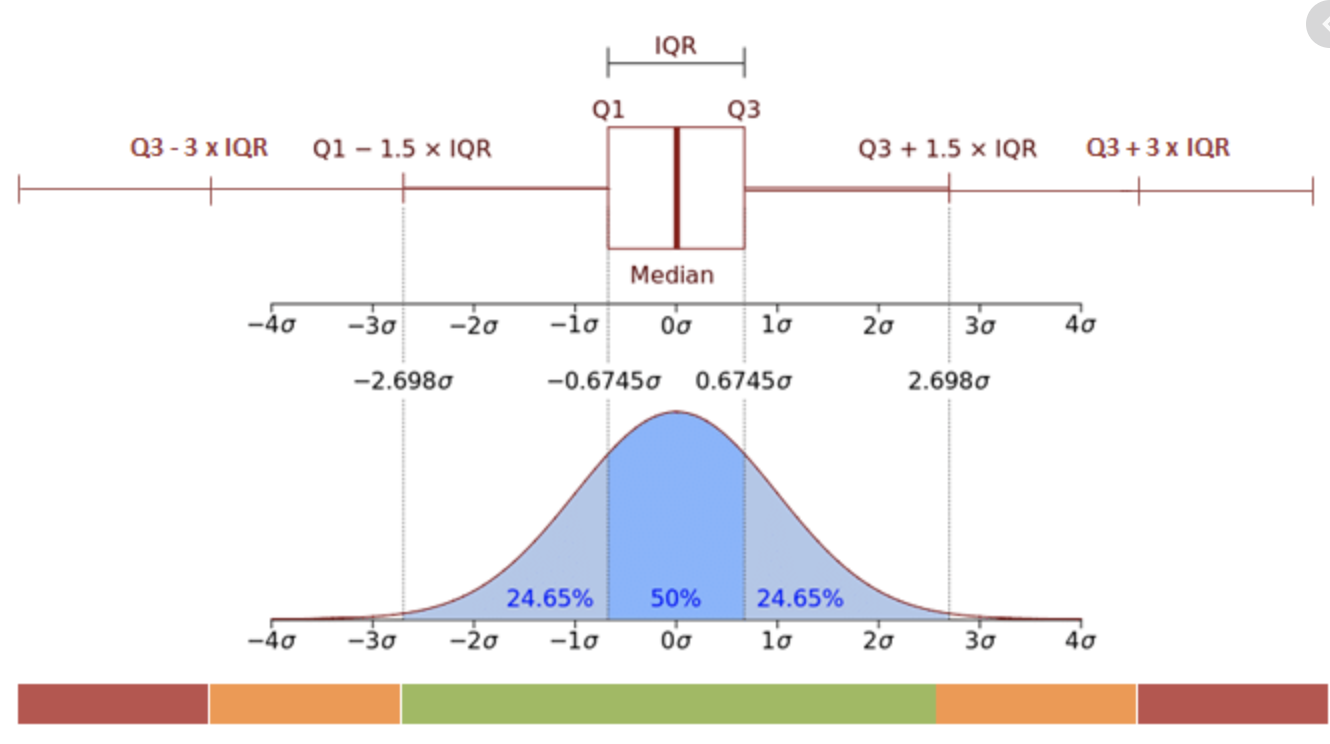


In [20]:
#child_mort
country_data['child_mort'].loc[country_data['child_mort'] > ((2.698 * country_data['child_mort'].std()) + country_data['child_mort'].median())] = ((2.698 * country_data['child_mort'].std()) + country_data['child_mort'].median())
country_data['child_mort'].loc[country_data['child_mort'] < ((country_data['child_mort'].median()) - (2.698 * country_data['child_mort'].std()))] = (country_data['child_mort'].median()-(2.698 * country_data['child_mort'].std()))

#income
country_data['income'].loc[country_data['income'] > ((2.698 * country_data['income'].std()) + country_data['income'].median())] = ((2.698 * country_data['income'].std()) + country_data['income'].median())
country_data['income'].loc[country_data['income'] < ((country_data['income'].median()) - (2.698 * country_data['income'].std()))] = (country_data['income'].median()-(2.698 * country_data['income'].std()))

#inflation
country_data['inflation'].loc[country_data['inflation'] > ((2.698 * country_data['inflation'].std()) + country_data['inflation'].median())] = ((2.698 * country_data['inflation'].std()) + country_data['inflation'].median())
country_data['inflation'].loc[country_data['inflation'] < ((country_data['inflation'].median()) - (2.698 * country_data['inflation'].std()))] = (country_data['inflation'].median()-(2.698 * country_data['inflation'].std()))

#life_expec
country_data['life_expec'].loc[country_data['life_expec'] > ((2.698 * country_data['life_expec'].std()) + country_data['life_expec'].median())] = ((2.698 * country_data['life_expec'].std()) + country_data['life_expec'].median())
country_data['life_expec'].loc[country_data['life_expec'] < ((country_data['life_expec'].median()) - (2.698 * country_data['life_expec'].std()))] = (country_data['life_expec'].median()-(2.698 * country_data['life_expec'].std()))

#total_fer
country_data['total_fer'].loc[country_data['total_fer'] > ((2.698 * country_data['total_fer'].std()) + country_data['total_fer'].median())] = ((2.698 * country_data['total_fer'].std()) + country_data['total_fer'].median())
country_data['total_fer'].loc[country_data['total_fer'] < ((country_data['total_fer'].median()) - (2.698 * country_data['total_fer'].std()))] = (country_data['total_fer'].median()-(2.698 * country_data['total_fer'].std()))

#gdpp
country_data['gdpp'].loc[country_data['gdpp'] > ((2.698 * country_data['gdpp'].std()) + country_data['gdpp'].median())] = ((2.698 * country_data['gdpp'].std()) + country_data['gdpp'].median())
country_data['gdpp'].loc[country_data['gdpp'] < ((country_data['gdpp'].median()) - (2.698 * country_data['gdpp'].std()))] = (country_data['gdpp'].median()-(2.698 * country_data['gdpp'].std()))

#exports_abs
country_data['exports_abs'].loc[country_data['exports_abs'] > ((2.698 * country_data['exports_abs'].std()) + country_data['exports_abs'].median())] = ((2.698 * country_data['exports_abs'].std()) + country_data['exports_abs'].median())
country_data['exports_abs'].loc[country_data['exports_abs'] < ((country_data['exports_abs'].median()) - (2.698 * country_data['exports_abs'].std()))] = (country_data['exports_abs'].median()-(2.698 * country_data['exports_abs'].std()))

#health_abs
country_data['health_abs'].loc[country_data['health_abs'] > ((2.698 * country_data['health_abs'].std()) + country_data['health_abs'].median())] = ((2.698 * country_data['health_abs'].std()) + country_data['health_abs'].median())
country_data['health_abs'].loc[country_data['health_abs'] < ((country_data['health_abs'].median()) - (2.698 * country_data['health_abs'].std()))] = (country_data['health_abs'].median()-(2.698 * country_data['health_abs'].std()))

#imports_abs
country_data['imports_abs'].loc[country_data['imports_abs'] > ((2.698 * country_data['imports_abs'].std()) + country_data['imports_abs'].median())] = ((2.698 * country_data['imports_abs'].std()) + country_data['imports_abs'].median())
country_data['imports_abs'].loc[country_data['imports_abs'] < ((country_data['imports_abs'].median()) - (2.698 * country_data['imports_abs'].std()))] = (country_data['imports_abs'].median()-(2.698 * country_data['imports_abs'].std()))

**Column stats after outlier treatment**

In [21]:
country_data.describe()

,child_mort,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,1.670000e+02,167.000000,1.670000e+02
mean,37.279909,16335.906347,7.258654,70.682747,2.940823,12214.779808,6.364283e+05,96449.470473,5.707493e+05
std,37.361300,16279.440274,7.302858,8.472903,1.494881,15706.675176,1.060344e+06,148295.766219,8.635181e+05
min,2.600000,609.000000,-4.210000,49.106222,1.150000,231.000000,1.076920e+02,1282.120000,6.510920e+01
25%,8.250000,3355.000000,1.810000,65.300000,1.795000,1330.000000,4.471400e+04,7853.550000,6.402150e+04
50%,19.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000,1.777440e+05,32188.600000,2.045580e+05
75%,62.100000,22800.000000,10.750000,76.800000,3.880000,14050.000000,7.278000e+05,97694.000000,7.719600e+05
max,128.107457,61972.226648,33.909759,82.800000,6.494361,54110.845574,5.027098e+06,518208.722721,4.173535e+06


**Column stats copy from before outlier treatment, brought down from top for comparison. Notice the reduction in maximum values across columns, as most of the outliers were on the upper end.**

In [9]:
country_data.describe()

,child_mort,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs
count,167.000000,167.000000,167.000000,167.000000,167.000000,167.000000,1.670000e+02,167.000000,1.670000e+02
mean,38.270060,17144.688623,7.781832,70.555689,2.947964,12964.155689,7.420619e+05,105673.320419,6.588352e+05
std,40.328931,19278.067698,10.570704,8.893172,1.513848,18328.704809,1.797389e+06,180140.890556,1.471081e+06
min,2.600000,609.000000,-4.210000,32.100000,1.150000,231.000000,1.076920e+02,1282.120000,6.510920e+01
25%,8.250000,3355.000000,1.810000,65.300000,1.795000,1330.000000,4.471400e+04,7853.550000,6.402150e+04
50%,19.300000,9960.000000,5.390000,73.100000,2.410000,4660.000000,1.777440e+05,32188.600000,2.045580e+05
75%,62.100000,22800.000000,10.750000,76.800000,3.880000,14050.000000,7.278000e+05,97694.000000,7.719600e+05
max,208.000000,125000.000000,104.000000,82.800000,7.490000,105000.000000,1.837500e+07,866360.000000,1.491000e+07


**Scaling the columns**

In [22]:
scaler = StandardScaler()
numeric_columns = ["child_mort", "income" , "inflation" , "life_expec" , "total_fer" , "gdpp" , "exports_abs" , "health_abs" , "imports_abs"]
country_data_scaled = country_data.copy()
country_data_scaled[numeric_columns] = scaler.fit_transform(country_data_scaled[numeric_columns])
country_data_scaled.head()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs
0,Afghanistan,1.420701,-0.907291,0.299596,-1.714442,1.931816,-0.744706,-0.596784,-0.623991,-0.634105
1,Albania,-0.555176,-0.394680,-0.380260,0.664961,-0.866092,-0.518838,-0.493687,-0.471149,-0.432063
2,Algeria,-0.267922,-0.211693,1.214310,0.688636,-0.034100,-0.495210,-0.440011,-0.526552,-0.500280
3,Angola,2.193871,-0.642976,2.079581,-1.252767,2.159943,-0.554599,-0.393987,-0.584297,-0.487046
4,Antigua and Barbuda,-0.724307,0.170301,-0.799160,0.724150,-0.544031,-0.000944,-0.076931,-0.154774,0.171711


**Defining hopkins statistics function**

In [23]:
 from sklearn.neighbors import NearestNeighbors
from random import sample
from numpy.random import uniform
import numpy as np
from math import isnan
 
def hopkins(X):
    d = X.shape[1]
    #d = len(vars) # columns
    n = len(X) # rows
    m = int(0.1 * n) 
    nbrs = NearestNeighbors(n_neighbors=1).fit(X.values)
 
    rand_X = sample(range(0, n, 1), m)
 
    ujd = []
    wjd = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(uniform(np.amin(X,axis=0),np.amax(X,axis=0),d).reshape(1, -1), 2, return_distance=True)
        ujd.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(X.iloc[rand_X[j]].values.reshape(1, -1), 2, return_distance=True)
        wjd.append(w_dist[0][1])
 
    H = sum(ujd) / (sum(ujd) + sum(wjd))
    if isnan(H):
        print(ujd, wjd)
        H = 0
 
    return H

**Given Hopkins value is in range of 0.77 - 0.9 the data has high tendency to cluster**

In [25]:
hopkins(country_data_scaled[numeric_columns])

0.835080844693242

In [30]:
kmeans = KMeans(n_clusters=5, verbose=0,max_iter=50)
kmeans.fit(country_data_scaled[numeric_columns])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=5, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [31]:
kmeans.labels_

array([0, 1, 4, 0, 1, 4, 1, 3, 2, 4, 3, 3, 1, 1, 4, 2, 1, 0, 1, 1, 1, 0,
       1, 3, 1, 0, 0, 1, 0, 3, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 3, 3,
       2, 1, 1, 1, 1, 0, 0, 1, 1, 3, 3, 0, 0, 1, 3, 0, 3, 1, 1, 0, 0, 1,
       0, 1, 3, 1, 4, 4, 4, 2, 3, 3, 1, 3, 1, 4, 0, 0, 3, 1, 0, 1, 1, 0,
       0, 4, 1, 2, 1, 0, 0, 1, 1, 0, 2, 0, 1, 1, 1, 4, 1, 1, 0, 1, 0, 4,
       2, 3, 0, 0, 2, 4, 0, 1, 1, 1, 1, 1, 3, 2, 1, 4, 0, 1, 4, 0, 1, 1,
       0, 2, 3, 3, 0, 0, 3, 3, 4, 1, 0, 1, 2, 2, 4, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 4, 2, 3, 3, 1, 4, 1, 4, 1, 4, 0], dtype=int32)

**Determining optimal number of clusters with the help of Sum of Square Distances or elbow curve method**

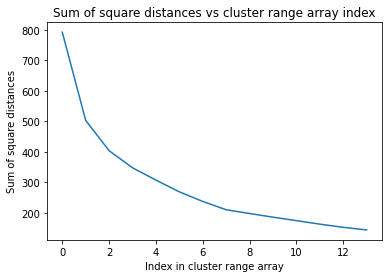

In [219]:
ssd = []
cluster_range = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
for num_clusters in cluster_range:
  kmeans = KMeans(n_clusters=num_clusters, verbose=0,max_iter=50)
  kmeans.fit(country_data_scaled[numeric_columns])
  ssd.append(kmeans.inertia_)

plt.plot(ssd)
plt.xlabel("Index in cluster range array")
plt.ylabel("Sum of square distances")
plt.title("Sum of square distances vs cluster range array index")
plt.show()

**Determining optimal number of clusters with the help of Silhoutte score method**

In [220]:
cluster_range = [2,3,4,5,6,7,8,9,10,11,12,13,14,15]
for num_clusters in cluster_range:
  kmeans = KMeans(n_clusters=num_clusters, verbose=0,max_iter=50)
  kmeans.fit(country_data_scaled[numeric_columns])
  cluster_labels = kmeans.labels_
  sil_avg = silhouette_score(country_data_scaled[numeric_columns],cluster_labels)
  print("For",num_clusters,"clusters, Silhouette score is:",sil_avg)

For 2 clusters, Silhouette score is: 0.4834991457405332
For 3 clusters, Silhouette score is: 0.41278062890648703
For 4 clusters, Silhouette score is: 0.39594880315682435
For 5 clusters, Silhouette score is: 0.37940355788531294
For 6 clusters, Silhouette score is: 0.29479892228279037
For 7 clusters, Silhouette score is: 0.3208016400988546
For 8 clusters, Silhouette score is: 0.33822235751873186
For 9 clusters, Silhouette score is: 0.31806476709521836
For 10 clusters, Silhouette score is: 0.30391255110072674
For 11 clusters, Silhouette score is: 0.284487682519972
For 12 clusters, Silhouette score is: 0.27643540740556516
For 13 clusters, Silhouette score is: 0.2775904774857871
For 14 clusters, Silhouette score is: 0.26905498259746435
For 15 clusters, Silhouette score is: 0.2718071481688423


**Choosing cluster size:**
*   Elbow curve method: From index 2 (on x-axis) we are seeing flattening of the curve, thus I am choosing index 2 as my cluster point, which corresponds to number of clusters = 3 from the list
*   Silhouette score method: From cluster size 3 is a sweet-spot with Silhouette score being 2nd highest, and also maintains symmetery with elbow curve outcome. 

Given a high Silhouette score for cluster size 3, it doesn't go against our decision of choosing 3 as number of clusters in elbow curve method.



**fitting final model**

In [186]:
kmeans = KMeans(n_clusters=3, verbose=0,max_iter=50)
kmeans.fit(country_data_scaled[numeric_columns])

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=50,
       n_clusters=3, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

In [187]:
country_data_scaled["cluster"] = 0
country_data_scaled["cluster"] = kmeans.labels_
country_data_scaled.head()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs,cluster
0,Afghanistan,1.420701,-0.907291,0.299596,-1.714442,1.931816,-0.744706,-0.596784,-0.623991,-0.634105,2
1,Albania,-0.555176,-0.394680,-0.380260,0.664961,-0.866092,-0.518838,-0.493687,-0.471149,-0.432063,0
2,Algeria,-0.267922,-0.211693,1.214310,0.688636,-0.034100,-0.495210,-0.440011,-0.526552,-0.500280,0
3,Angola,2.193871,-0.642976,2.079581,-1.252767,2.159943,-0.554599,-0.393987,-0.584297,-0.487046,2
4,Antigua and Barbuda,-0.724307,0.170301,-0.799160,0.724150,-0.544031,-0.000944,-0.076931,-0.154774,0.171711,0


**Plotting Child mortality rates across clusters**

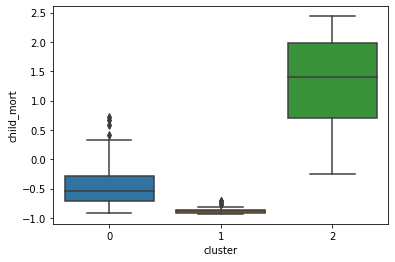

In [188]:
sns.boxplot(x='cluster',y='child_mort',data=country_data_scaled)

**Plotting GDPP across clusters**

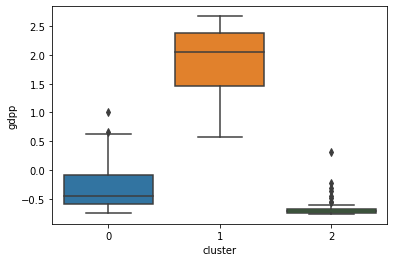

In [189]:
sns.boxplot(x='cluster',y='gdpp',data=country_data_scaled)

**Plotting Income across clusters**

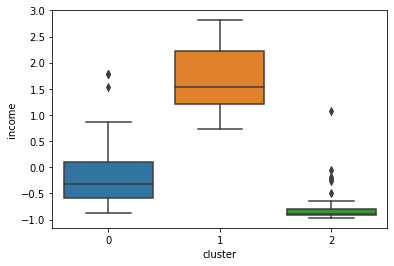

In [190]:
sns.boxplot(x='cluster',y='income',data=country_data_scaled)

**Cluster 2 has lowest income and gdpp, along with highest child mortality rates, thus countries in this cluster are the ones we should be providing aid**

# **Profiling & visualising clusters based on "Child mortality" , "Income per capita" and "GDPP" **

**Income per Capita vs Child Mortality per 1000 across clusters**

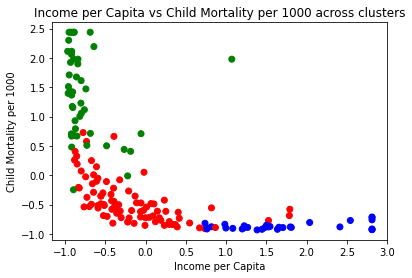

In [201]:
scatter_data = country_data_scaled.copy()
scatter_data["color"] = "black"
scatter_data["color"].loc[scatter_data["cluster"]==0] = "red"
scatter_data["color"].loc[scatter_data["cluster"]==1] = "blue"
scatter_data["color"].loc[scatter_data["cluster"]==2] = "green"
fig, ax = plt.subplots()
ax.scatter(scatter_data['income'], scatter_data['child_mort'], c = scatter_data["color"])
plt.title("Income per Capita vs Child Mortality per 1000 across clusters")
plt.xlabel("Income per Capita")
plt.ylabel("Child Mortality per 1000")
plt.show()

**The cluster of interest is the one in Green (Cluster number 2), having low income per capita and high child mortality**

**Income per Capita vs Child Mortality per 1000 across clusters**

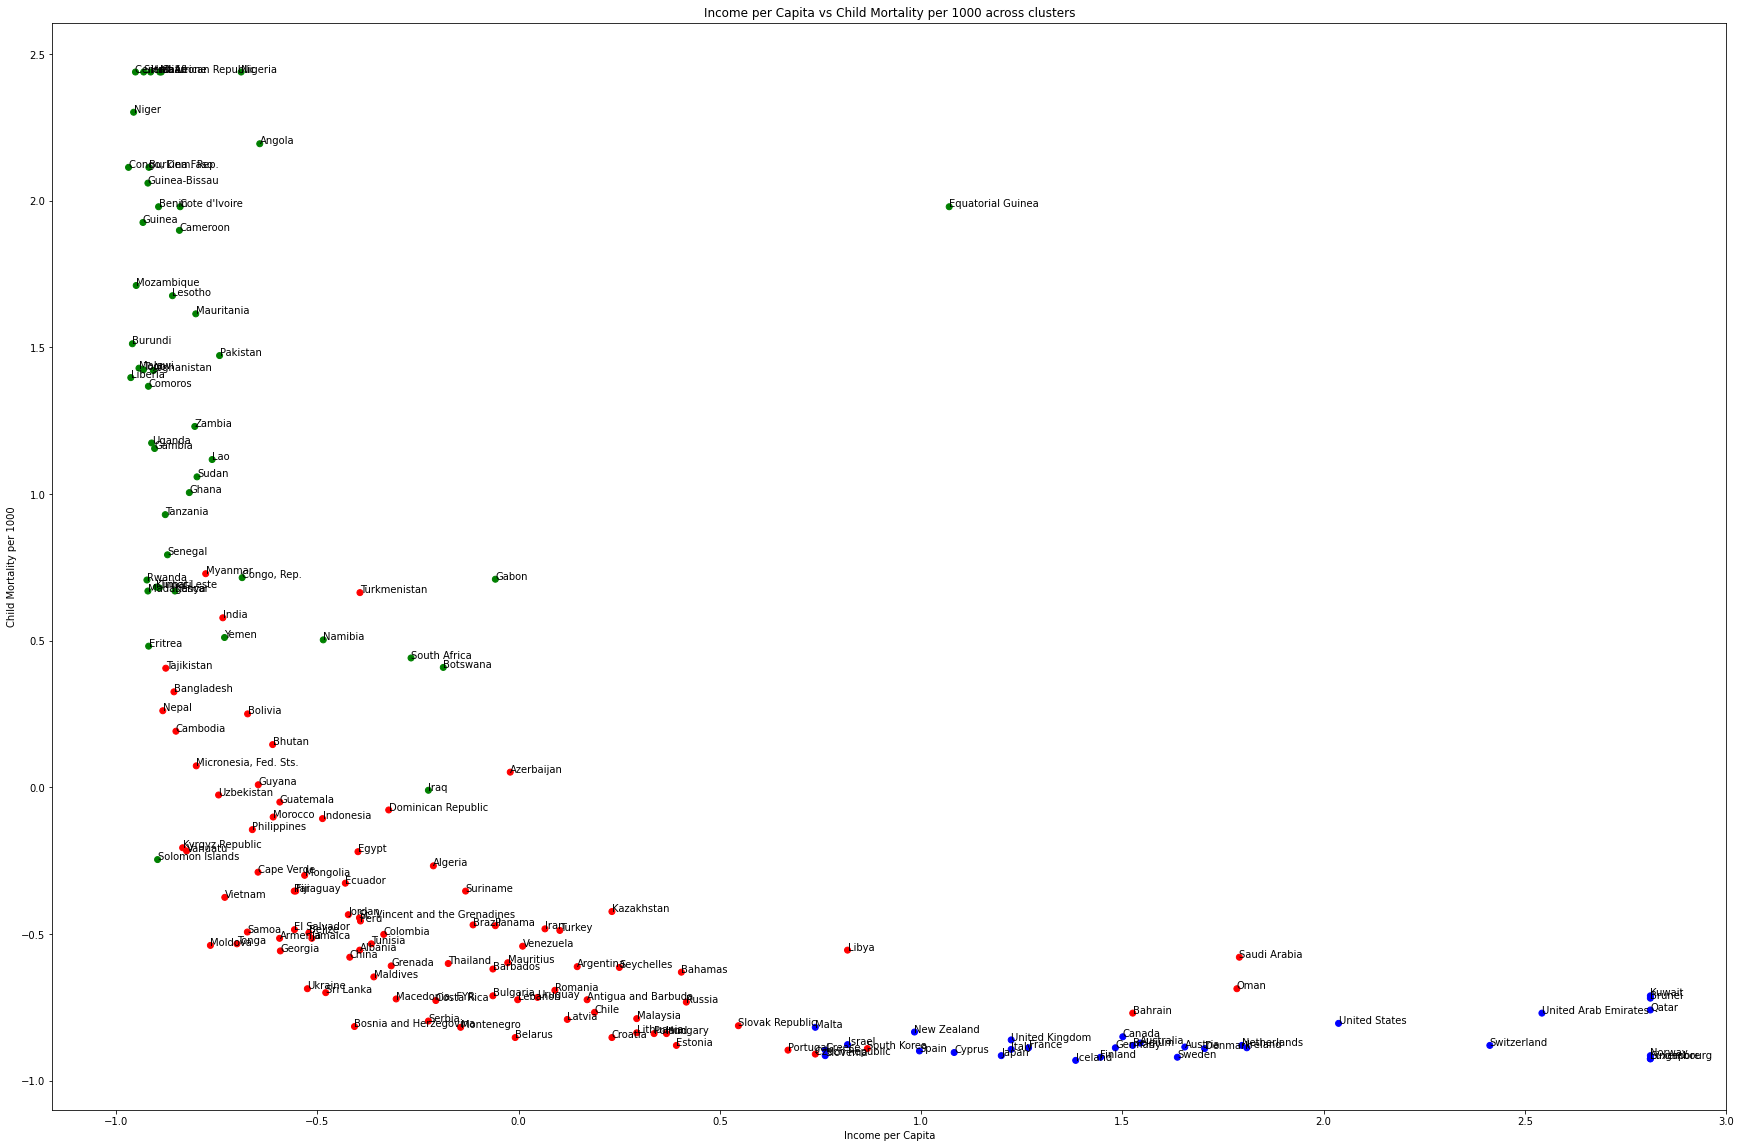

In [193]:
x = list(scatter_data['income'])
y = list(scatter_data['child_mort'])
labels = list(scatter_data['country'])

fig, ax = plt.subplots(figsize=(30,20))
ax.scatter(x, y, c = scatter_data["color"])

for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))

plt.title("Income per Capita vs Child Mortality per 1000 across clusters")
plt.xlabel("Income per Capita")
plt.ylabel("Child Mortality per 1000")
plt.show()

**Target cluster 2 (in Green) has both low GDPP and Income per Capita**

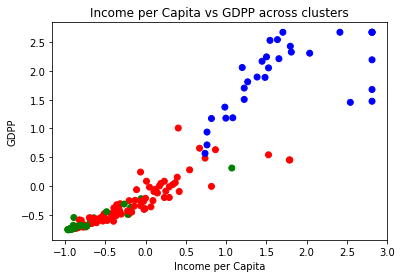

In [202]:
fig, ax = plt.subplots()
ax.scatter(scatter_data['income'], scatter_data['gdpp'], c = scatter_data["color"])
plt.title("Income per Capita vs GDPP across clusters")
plt.xlabel("Income per Capita")
plt.ylabel("GDPP")
plt.show()

**Target cluster 2 (in Green) have high child mortality rate and low GDPP**

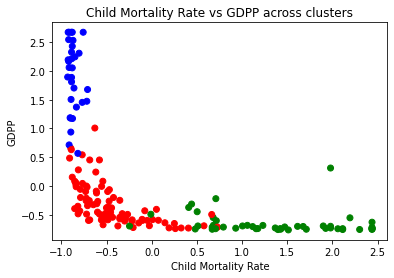

In [203]:
fig, ax = plt.subplots()
ax.scatter(scatter_data['child_mort'], scatter_data['gdpp'], c = scatter_data["color"])
plt.title("Child Mortality Rate vs GDPP across clusters")
plt.xlabel("Child Mortality Rate")
plt.ylabel("GDPP")
plt.show()

**Identifying top countries for aid based on a common composite index**

Given cluster 2 (marked in Green) have a significant number of countries we need to apply a stack rank method to determine top countries in need of aid (prioritisation of limited funds). 

This would be done by filtering countries from this cluster and adding a composite column = min_max_scaled_values ((child mortality + (1-GDPP) + (1-income)).

Given GDPP and Income moves in opposite direction to child mortality we are inversing them by substracting them from 1.

Post which we would sort in descending order and pick top countries from the list 

In [196]:
kmeans_priority = country_data_scaled.loc[(country_data_scaled['cluster']== 2)].copy()
kmeans_priority = kmeans_priority.reset_index()
kmeans_priority = kmeans_priority.drop(['index', "inflation" , "life_expec" , "total_fer" , "exports_abs" , "health_abs" , "imports_abs"],axis=1)
kmeans_priority["composite_metrics"] = 0

scaler = MinMaxScaler()

target_columns = ["child_mort", "income" ,"gdpp"]
kmeans_priority[target_columns] = scaler.fit_transform(kmeans_priority[target_columns])
kmeans_priority.head()

,country,child_mort,income,gdpp,cluster,composite_metrics
0,Afghanistan,0.620954,0.030250,0.019088,2,0
1,Angola,0.908932,0.159892,0.195566,2,0
2,Benin,0.828938,0.036596,0.031241,2,0
3,Botswana,0.243982,0.383518,0.362736,2,0
4,Burkina Faso,0.878934,0.024810,0.020392,2,0


In [197]:
kmeans_priority["composite_metrics"] = kmeans_priority['child_mort'] + (1- kmeans_priority['gdpp']) +  (1 - kmeans_priority['income'])
kmeans_priority = kmeans_priority.sort_values(by='composite_metrics' , ascending=False)
kmeans_priority = kmeans_priority.reset_index()
kmeans_priority = kmeans_priority.drop(['index'], axis = 1)
kmeans_priority.head(10)

,country,child_mort,income,gdpp,cluster,composite_metrics
0,Central African Republic,1.000000,0.008431,0.012745,2,2.978823
1,Sierra Leone,1.000000,0.018464,0.009959,2,2.971577
2,Haiti,1.000000,0.026926,0.025550,2,2.947524
3,Niger,0.948929,0.006195,0.006936,2,2.935798
4,Mali,1.000000,0.038107,0.028277,2,2.933616
5,Chad,1.000000,0.039920,0.039481,2,2.920599
6,"Congo, Dem. Rep.",0.878934,0.000000,0.006106,2,2.872829
7,Burkina Faso,0.878934,0.024810,0.020392,2,2.833732
8,Guinea-Bissau,0.858936,0.023602,0.018733,2,2.816602
9,Guinea,0.808940,0.017558,0.024720,2,2.766662


# **Hierarchical clustering**

**Implementing single linkage**

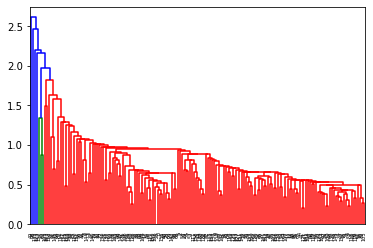

In [132]:
mergings = linkage(country_data_scaled[numeric_columns], method="single",metric="euclidean")
dendrogram(mergings)
plt.show()
#figsize=(15,15)

**The dendrogram from single linkage method is not appropriate as it is not able to appropriately segregate countries**

**Implementing complete linkage**

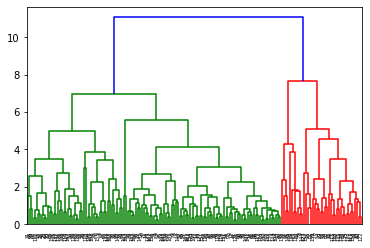

In [174]:
mergings = linkage(country_data_scaled[numeric_columns], method="complete",metric="euclidean")
dendrogram(mergings)
plt.show()

**Dendrogram from complete linkage method seems much better than single linkage. Leveraging complete linkage for clustering tasks ahead**

**Cutting the tree and extracting cluster labels**

In [181]:
cluster_labels = cut_tree(mergings, n_clusters = 3).reshape(-1, )
cluster_labels

array([0, 0, 0, 0, 0, 0, 0, 1, 2, 0, 1, 1, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1,
       2, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 2, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 2, 0, 0, 0, 0, 0, 0, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       2, 1, 0, 0, 2, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 2, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0])

**appending cluster labels to scaled data frame**

In [182]:
country_data_scaled_hierarchy = country_data_scaled.copy()

country_data_scaled_hierarchy["cluster_labels_hierarchy"] = cluster_labels
country_data_scaled_hierarchy.head()

,country,child_mort,income,inflation,life_expec,total_fer,gdpp,exports_abs,health_abs,imports_abs,cluster,cluster_labels_hierarchy
0,Afghanistan,1.420701,-0.907291,0.299596,-1.714442,1.931816,-0.744706,-0.596784,-0.623991,-0.634105,4,0
1,Albania,-0.555176,-0.394680,-0.380260,0.664961,-0.866092,-0.518838,-0.493687,-0.471149,-0.432063,3,0
2,Algeria,-0.267922,-0.211693,1.214310,0.688636,-0.034100,-0.495210,-0.440011,-0.526552,-0.500280,3,0
3,Angola,2.193871,-0.642976,2.079581,-1.252767,2.159943,-0.554599,-0.393987,-0.584297,-0.487046,0,0
4,Antigua and Barbuda,-0.724307,0.170301,-0.799160,0.724150,-0.544031,-0.000944,-0.076931,-0.154774,0.171711,3,0


# **Cluster profiling and visualisation**

**Cluster 0 has highest child mortality**

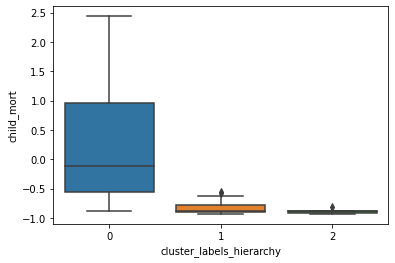

In [183]:
sns.boxplot(x='cluster_labels_hierarchy',y='child_mort',data=country_data_scaled_hierarchy)

**Cluster 0 has lowest GDPP**

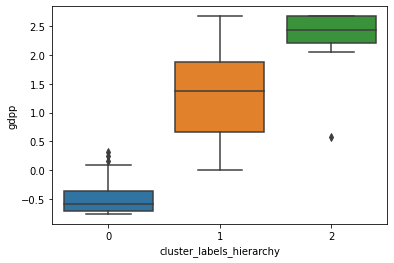

In [184]:
sns.boxplot(x='cluster_labels_hierarchy',y='gdpp',data=country_data_scaled_hierarchy)

**Cluster 0 has lowest income per capita**

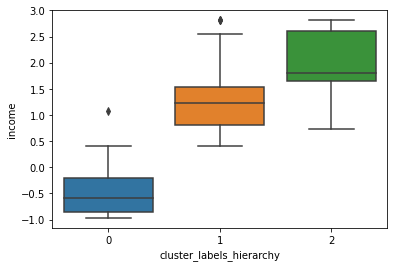

In [185]:
sns.boxplot(x='cluster_labels_hierarchy',y='income',data=country_data_scaled_hierarchy)

**Cluster 0 (in Green) has highest Child mortality rate and lowest income per capita**

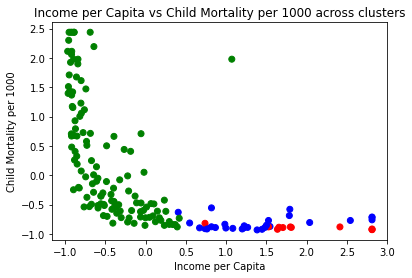

In [207]:
scatter_data = country_data_scaled_hierarchy.copy()
scatter_data["color"] = "black"
scatter_data["color"].loc[scatter_data["cluster_labels_hierarchy"]==0] = "green"
scatter_data["color"].loc[scatter_data["cluster_labels_hierarchy"]==1] = "blue"
scatter_data["color"].loc[scatter_data["cluster_labels_hierarchy"]==2] = "red"
fig, ax = plt.subplots()
ax.scatter(scatter_data['income'], scatter_data['child_mort'], c = scatter_data["color"])
plt.title("Income per Capita vs Child Mortality per 1000 across clusters")
plt.xlabel("Income per Capita")
plt.ylabel("Child Mortality per 1000")
plt.show()

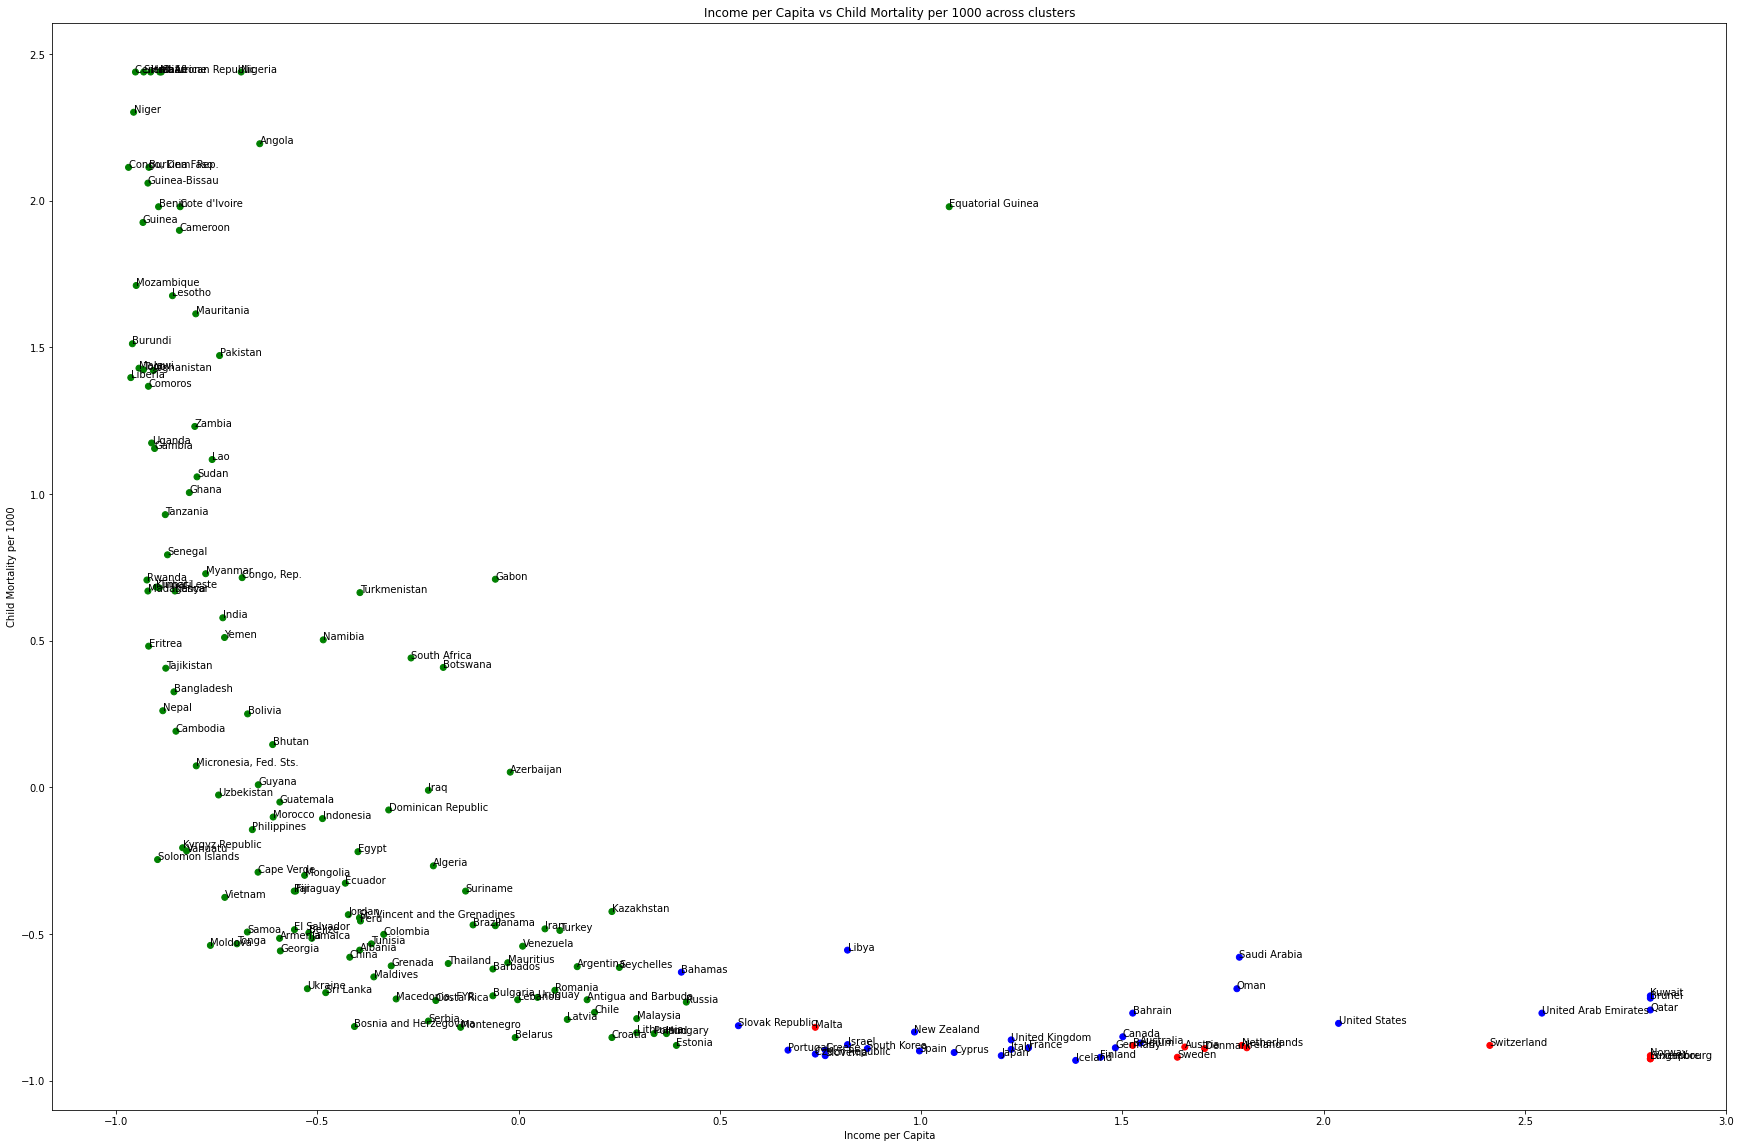

In [213]:
x = list(scatter_data['income'])
y = list(scatter_data['child_mort'])
labels = list(scatter_data['country'])

fig, ax = plt.subplots(figsize=(30,20))
ax.scatter(x, y, c = scatter_data["color"])

for i, txt in enumerate(labels):
    ax.annotate(txt, (x[i], y[i]))

plt.title("Income per Capita vs Child Mortality per 1000 across clusters")
plt.xlabel("Income per Capita")
plt.ylabel("Child Mortality per 1000")
plt.show()

**Cluster 0 (in green) has lowest GDPP and Income per capita**

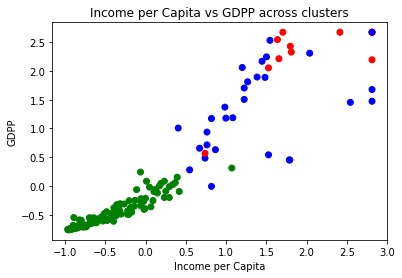

In [210]:
fig, ax = plt.subplots()
ax.scatter(scatter_data['income'], scatter_data['gdpp'], c = scatter_data["color"])
plt.title("Income per Capita vs GDPP across clusters")
plt.xlabel("Income per Capita")
plt.ylabel("GDPP")
plt.show()

**Cluster 0 (in Green) has lowest GDPP and highest Child mortality rate**

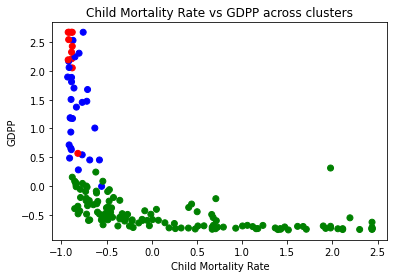

In [209]:
fig, ax = plt.subplots()
ax.scatter(scatter_data['child_mort'], scatter_data['gdpp'], c = scatter_data["color"])
plt.title("Child Mortality Rate vs GDPP across clusters")
plt.xlabel("Child Mortality Rate")
plt.ylabel("GDPP")
plt.show()

**Identifying top countries for aid based on a common composite index**

Given cluster 0 (marked in Green) have a significant number of countries we need to apply a stack rank method to determine top countries in need of aid (prioritisation of limited funds). 

This would be done by filtering countries from this cluster and adding a composite column = min_max_scaled_values ((child mortality + (1-GDPP) + (1-income)).

Given GDPP and Income moves in opposite direction to child mortality we are inversing them by substracting them from 1.

Post which we would sort in descending order and pick top countries from the list 

In [215]:
hierarchy_priority = country_data_scaled_hierarchy.loc[(country_data_scaled_hierarchy['cluster_labels_hierarchy']== 0)].copy()
hierarchy_priority = hierarchy_priority.reset_index()
hierarchy_priority = hierarchy_priority.drop(['index', "inflation" , "life_expec" , "total_fer" , "exports_abs" , "health_abs" , "imports_abs"],axis=1)
hierarchy_priority["composite_metrics"] = 0

scaler = MinMaxScaler()

target_columns = ["child_mort", "income" ,"gdpp"]
hierarchy_priority[target_columns] = scaler.fit_transform(hierarchy_priority[target_columns])
hierarchy_priority.head()

,country,child_mort,income,gdpp,cluster,cluster_labels_hierarchy,composite_metrics
0,Afghanistan,0.693324,0.030250,0.019088,4,0,0
1,Albania,0.097891,0.281678,0.228763,3,0,0
2,Algeria,0.184455,0.371430,0.250697,3,0,0
3,Angola,0.926320,0.159892,0.195566,0,0,0
4,Antigua and Barbuda,0.046923,0.558792,0.709526,3,0,0


In [216]:
hierarchy_priority["composite_metrics"] = hierarchy_priority['child_mort'] + (1- hierarchy_priority['gdpp']) +  (1 - hierarchy_priority['income'])
hierarchy_priority = hierarchy_priority.sort_values(by='composite_metrics' , ascending=False)
hierarchy_priority = hierarchy_priority.reset_index()
hierarchy_priority = hierarchy_priority.drop(['index'], axis = 1)
hierarchy_priority.head(10)

,country,child_mort,income,gdpp,cluster,cluster_labels_hierarchy,composite_metrics
0,Central African Republic,1.000000,0.008431,0.012745,4,0,2.978823
1,Sierra Leone,1.000000,0.018464,0.009959,4,0,2.971577
2,Haiti,1.000000,0.026926,0.025550,4,0,2.947524
3,Niger,0.958680,0.006195,0.006936,4,0,2.945549
4,Mali,1.000000,0.038107,0.028277,4,0,2.933616
5,Chad,1.000000,0.039920,0.039481,4,0,2.920599
6,"Congo, Dem. Rep.",0.902049,0.000000,0.006106,0,0,2.895943
7,Burkina Faso,0.902049,0.024810,0.020392,4,0,2.856846
8,Guinea-Bissau,0.885869,0.023602,0.018733,4,0,2.843535
9,Guinea,0.845418,0.017558,0.024720,4,0,2.803141


**The above is the list of top 10 countries from the cluster which is in dire need of aid.**

The list of top 10 countries in need of aid is same from both "kMeans" and "Hierarchical" clustering methods because we have used clustering for choosing the broder subset of countries to provide aid to, however, inside a cluster I have done prioritisation through a composite metric which is calculated the same way for both clustering methods. 

**The high-degree of overlap in countries in dire need of aid showcases robust clustering through both kMeans and Hierarchical methods**

**Hierarchical clustering top 25 countries needing aid**

In [226]:
hierarchy_priority.head(25)

,country,child_mort,income,gdpp,cluster,cluster_labels_hierarchy,composite_metrics
0,Central African Republic,1.000000,0.008431,0.012745,4,0,2.978823
1,Sierra Leone,1.000000,0.018464,0.009959,4,0,2.971577
2,Haiti,1.000000,0.026926,0.025550,4,0,2.947524
3,Niger,0.958680,0.006195,0.006936,4,0,2.945549
4,Mali,1.000000,0.038107,0.028277,4,0,2.933616
5,Chad,1.000000,0.039920,0.039481,4,0,2.920599
6,"Congo, Dem. Rep.",0.902049,0.000000,0.006106,0,0,2.895943
7,Burkina Faso,0.902049,0.024810,0.020392,4,0,2.856846
8,Guinea-Bissau,0.885869,0.023602,0.018733,4,0,2.843535
9,Guinea,0.845418,0.017558,0.024720,4,0,2.803141


**K-means top 25 country needing aid**

In [227]:
kmeans_priority.head(25)

,country,child_mort,income,gdpp,cluster,composite_metrics
0,Central African Republic,1.000000,0.008431,0.012745,2,2.978823
1,Sierra Leone,1.000000,0.018464,0.009959,2,2.971577
2,Haiti,1.000000,0.026926,0.025550,2,2.947524
3,Niger,0.948929,0.006195,0.006936,2,2.935798
4,Mali,1.000000,0.038107,0.028277,2,2.933616
5,Chad,1.000000,0.039920,0.039481,2,2.920599
6,"Congo, Dem. Rep.",0.878934,0.000000,0.006106,2,2.872829
7,Burkina Faso,0.878934,0.024810,0.020392,2,2.833732
8,Guinea-Bissau,0.858936,0.023602,0.018733,2,2.816602
9,Guinea,0.808940,0.017558,0.024720,2,2.766662
